In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gc
from pathlib import Path


from sklearn.metrics import accuracy_score
from IPython.display import FileLink

In [2]:
!pip freeze | grep -e fastai -e torch

fastai==1.0.50.post1
torch==1.0.1.post2
torchaudio==0.2
torchtext==0.3.1
torchvision==0.2.2


In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
DATA_DIR = Path('../input')

In [5]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [6]:
label_mapper = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

In [7]:
train_df['label'] = train_df['label'].map(label_mapper)

In [8]:
train_df.head()

,image_name,label,valid
0,7238.jpg,forest,False
1,1532.jpg,forest,False
2,23230.jpg,glacier,False
3,19137.jpg,mountain,False
4,22805.jpg,forest,False


In [9]:
def get_ex(path): return open_image(path)

def plots_f(path, tfms, rows, cols, width, height, **kwargs):
    [get_ex(path).apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]

In [10]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75), jitter(magnitude=0.005, p=.25)])
len(tfms)

2

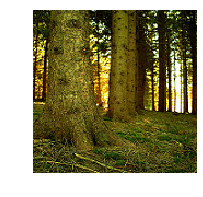

In [11]:
open_image(DATA_DIR/'images/images/7238.jpg').show()

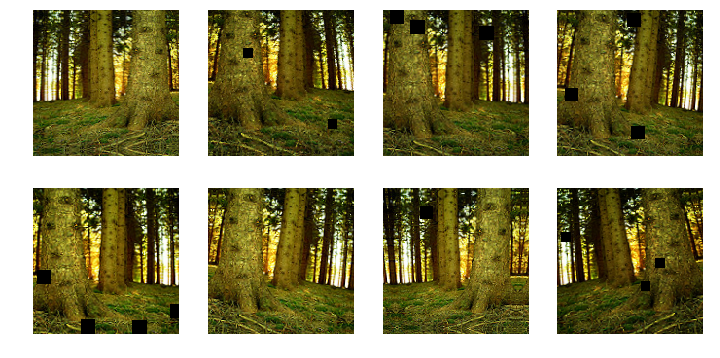

In [12]:
plots_f(DATA_DIR/'images/images/7238.jpg', tfms, 2, 4, 12, 6, size=150)

In [13]:
train_il = ImageList.from_df(df=train_df, cols='image_name', path=DATA_DIR/'images/images')
test_il = ImageList.from_df(df=test_df, cols='image_name', path=DATA_DIR/'images/images')

In [14]:
np.random.seed(0)
src1 = (train_il
        .split_from_df(col='valid')
        .label_from_df(cols='label')
        .add_test(test_il))

In [15]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75), jitter(magnitude=0.005, p=.25)])     
data1 = (src1
        .transform(tfms, size=150)
        .databunch(path='.', bs=128, num_workers=0)
        .normalize(imagenet_stats))

In [16]:
data1

ImageDataBunch;

Train: LabelList (13627 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
forest,forest,glacier,mountain,forest
Path: ../input/images/images;

Valid: LabelList (3407 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
street,glacier,buildings,buildings,sea
Path: ../input/images/images;

Test: LabelList (7301 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: EmptyLabelList
,,,,
Path: ../input/images/images

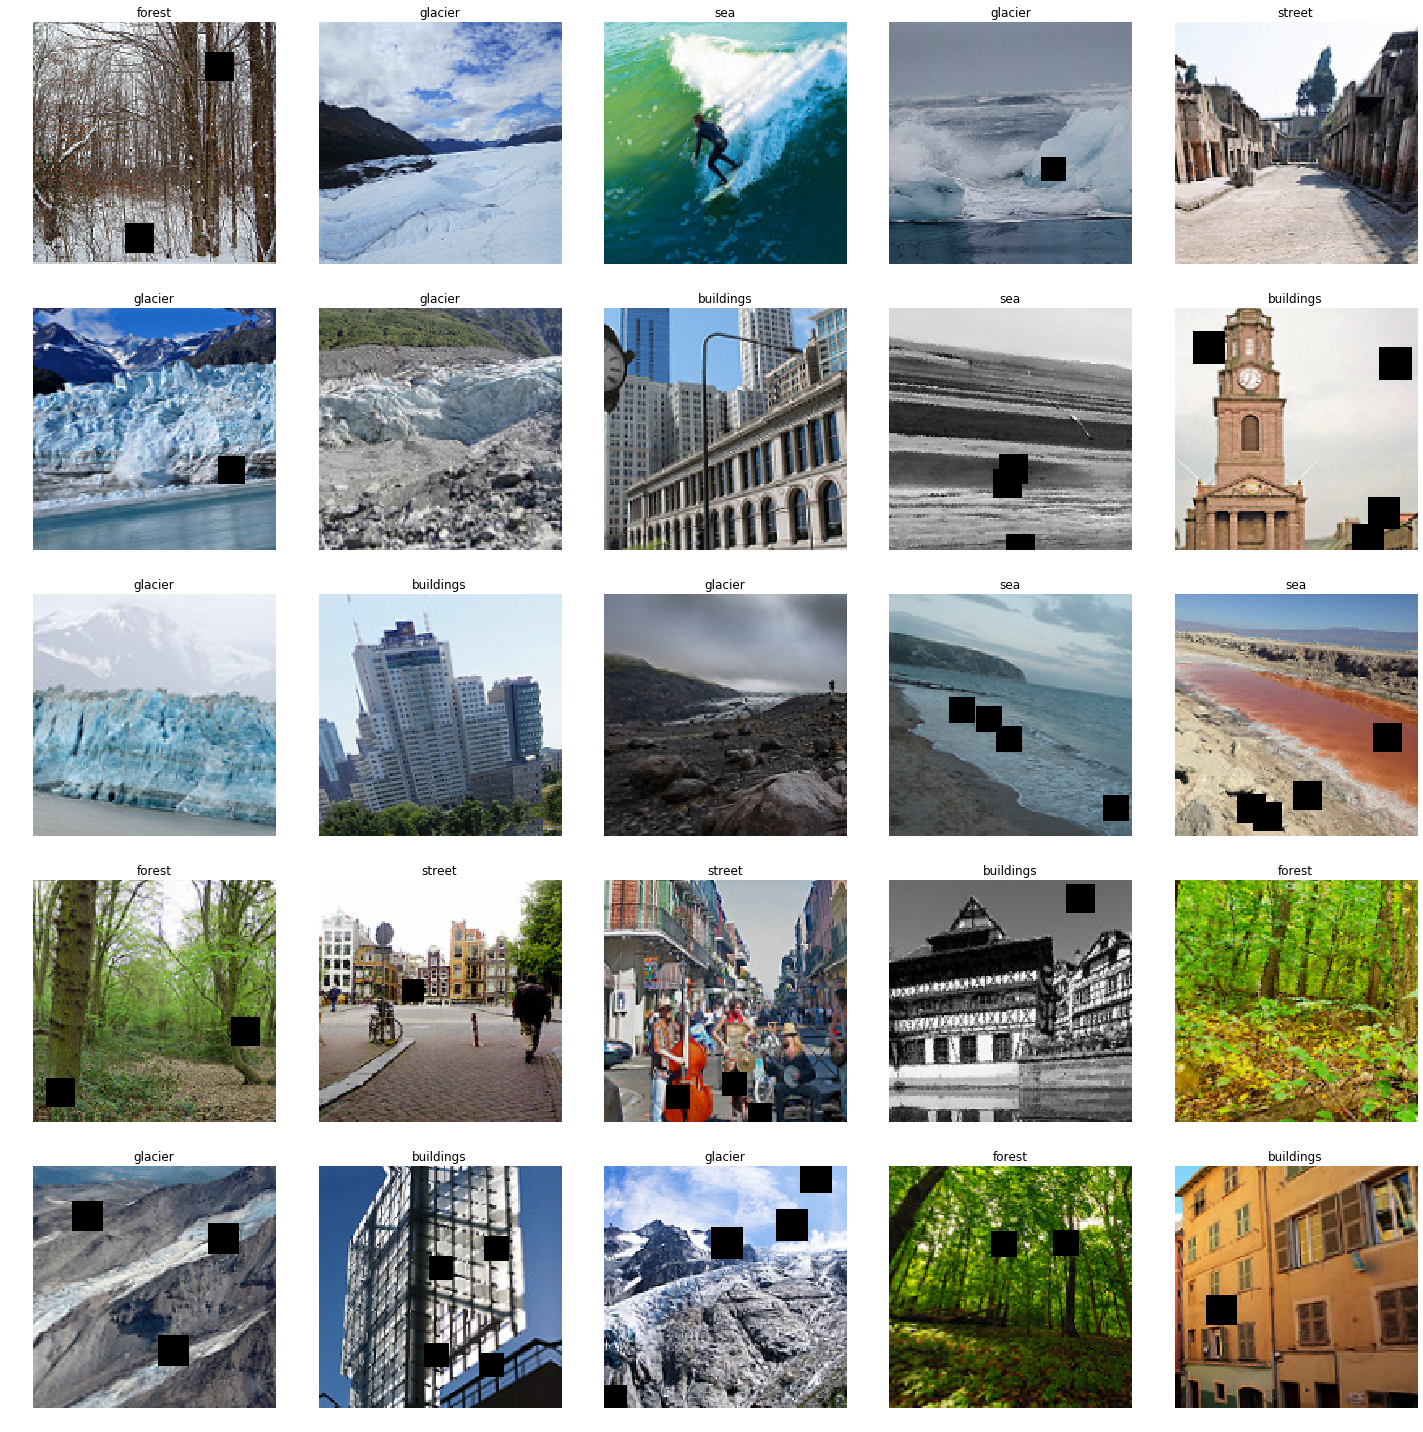

In [17]:
data1.show_batch()

In [31]:
learn1 = cnn_learner(data1, models.resnet101, metrics=[accuracy])

In [20]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


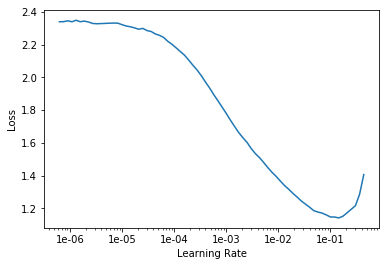

In [21]:
learn1.recorder.plot()

In [22]:
doc(fit_one_cycle)

In [32]:
rn101_stage1_callbacks = [CSVLogger(learn=learn1, filename='rn101-stage-history'), ShowGraph(learn=learn1)]

epoch,train_loss,valid_loss,accuracy,time
0,0.345907,0.239510,0.916055,02:03
1,0.297456,0.280030,0.912239,02:03
2,0.290069,0.390960,0.872028,02:04
3,0.250555,0.274637,0.914001,02:03
4,0.235445,0.190817,0.938069,02:03
5,0.189469,0.203264,0.932198,02:05
6,0.155437,0.169910,0.945700,02:04
7,0.119182,0.166670,0.947168,02:05


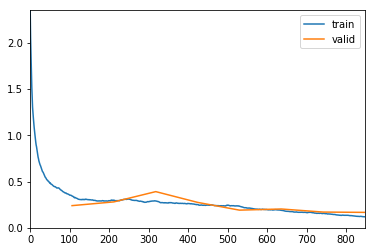

In [33]:
learn1.fit_one_cycle(8, 1e-2, callbacks=rn101_stage1_callbacks, wd=1e-4)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.345907	0.239510	0.916055	02:03
1	0.297456	0.280030	0.912239	02:03
2	0.290069	0.390960	0.872028	02:04
3	0.250555	0.274637	0.914001	02:03
4	0.235445	0.190817	0.938069	02:03
5	0.189469	0.203264	0.932198	02:05
6	0.155437	0.169910	0.945700	02:04
7	0.119182	0.166670	0.947168	02:05
</pre>

In [34]:
learn1.save('rn101-stage1')

In [35]:
learn1.unfreeze()

In [36]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


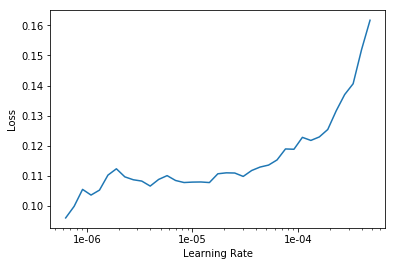

In [37]:
learn1.recorder.plot()

In [29]:
# rn101_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn101-stage2-history'), EarlyStoppingCallback(learn=learn1, monitor='accuracy', min_delta=0.005, patience=8), SaveModelCallback(learn=learn1, monitor='accuracy', name='rn101-stage2'), ShowGraph(learn=learn1)]     

In [40]:
learn1.wd

0.01

In [38]:
rn101_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn101-stage2-history'),ShowGraph(learn=learn1)]     

epoch,train_loss,valid_loss,accuracy,time
0,0.119249,0.167593,0.944820,02:20
1,0.111774,0.168699,0.947168,02:20


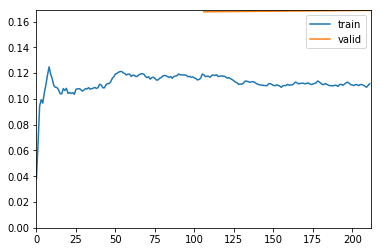

In [41]:
learn1.fit_one_cycle(2, slice(1e-6, 1e-5), callbacks=rn101_stage2_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.119249	0.167593	0.944820	02:20
1	0.111774	0.168699	0.947168	02:20
</pre>

In [42]:
learn1.save('rn101-stage2')

In [43]:
interp = ClassificationInterpretation.from_learner(learn1)

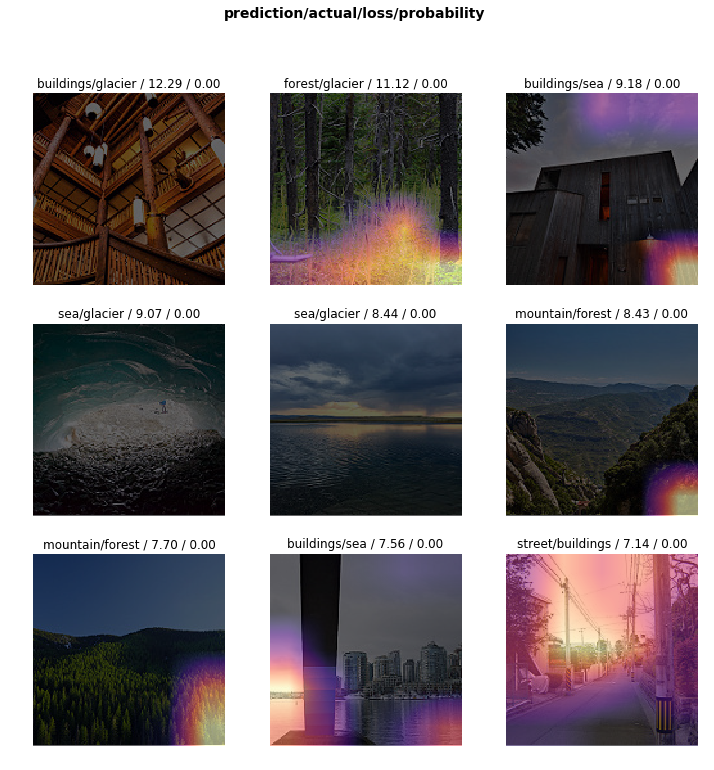

In [44]:
interp.plot_top_losses(9)

Some of the images are mis labeled.

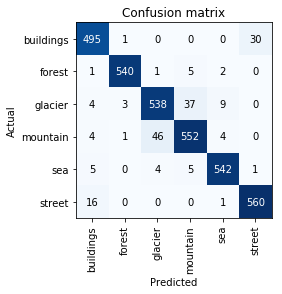

In [45]:
interp.plot_confusion_matrix()

Almost all the problem is with 

mountain and glacier

street and building

In [46]:
val_preds_tta = learn1.TTA(ds_type=DatasetType.Valid)

In [47]:
accuracy_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy())

0.9454065159964778

In [48]:
val_preds = learn1.get_preds()

In [49]:
accuracy_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy())

0.9471675961256237

In [50]:
val_img_names = [Path(i).name for i in learn1.data.valid_ds.x.items]

In [51]:
val_probs_tta_df = pd.DataFrame(val_preds_tta[0].numpy(), columns=learn1.data.train_ds.classes)
val_probs_tta_df['image_name'] = val_img_names
val_probs_tta_df['ground_label'] = val_preds_tta[1].numpy()

In [52]:
val_probs_df = pd.DataFrame(val_preds[0].numpy(), columns=learn1.data.train_ds.classes)
val_probs_df['image_name'] = val_img_names
val_probs_df['ground_label'] = val_preds[1].numpy()

In [53]:
test_preds_tta = learn1.TTA(ds_type=DatasetType.Test)

In [54]:
test_preds = learn1.get_preds(ds_type=DatasetType.Test)

In [55]:
test_img_names = [Path(i).name for i in learn1.data.test_ds.x.items]

In [56]:
test_probs_tta_df = pd.DataFrame(test_preds_tta[0].numpy(), columns=learn1.data.train_ds.classes)
test_probs_tta_df['image_name'] = test_img_names

In [57]:
test_probs_df = pd.DataFrame(test_preds[0].numpy(), columns=learn1.data.train_ds.classes)
test_probs_df['image_name'] = test_img_names

In [58]:
test_pred_tta_df = pd.DataFrame({'image_name': test_img_names})
test_pred_tta_df['label'] = test_preds_tta[0].argmax(1).numpy()

In [59]:
test_pred_df = pd.DataFrame({'image_name': test_img_names})
test_pred_df['label'] = test_preds[0].argmax(1).numpy()

In [60]:
val_probs_tta_df.to_csv('val_probs_tta.csv', index=False)
val_probs_df.to_csv('val_probs.csv', index=False)
test_probs_tta_df.to_csv('test_probs_tta.csv', index=False)
test_probs_df.to_csv('test_probs.csv', index=False)
test_pred_tta_df.to_csv('test_pred_tta.csv', index=False)
test_pred_df.to_csv('test_pred.csv', index=False)

In [61]:
!ls

__notebook_source__.ipynb  test_pred.csv       val_probs.csv
models			   test_pred_tta.csv   val_probs_tta.csv
rn101-stage-history.csv    test_probs.csv
rn101-stage2-history.csv   test_probs_tta.csv


In [62]:
!ls -lh models

total 871M
-rw-r--r-- 1 root root 188M Mar 31 07:23 rn101-stage1.pth
-rw-r--r-- 1 root root 512M Mar 31 07:35 rn101-stage2.pth
-rw-r--r-- 1 root root 171M Mar 31 07:23 tmp.pth


In [63]:
FileLink('val_probs_tta.csv')

/kaggle/working/val_probs_tta.csv

In [64]:
FileLink('val_probs.csv')

/kaggle/working/val_probs.csv

In [65]:
FileLink('test_probs_tta.csv')

/kaggle/working/test_probs_tta.csv

In [66]:
FileLink('test_probs.csv')

/kaggle/working/test_probs.csv

In [67]:
FileLink('test_pred_tta.csv')

/kaggle/working/test_pred_tta.csv

In [68]:
FileLink('test_pred.csv')

/kaggle/working/test_pred.csv

In [71]:
FileLink('rn101-stage-history.csv')

/kaggle/working/rn101-stage-history.csv

In [70]:
FileLink('rn101-stage2-history.csv')

/kaggle/working/rn101-stage2-history.csv